# 1. Import Required Libraries

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

# 2. Define Global Variables

In [36]:
SEQUENCE_LENGTH = 12  # 12 months lookback
MODEL_DIR = 'cinnamon_models/Quillings' # Directory to save models and preprocessors

# Create model directory
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3. Data Loading and Preparation

In [37]:
def load_and_prepare_data(data_path):
    """Load and prepare the cinnamon price dataset"""
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Rename 'Date' to 'Month' and 'Price' to 'Regional_Price' for consistency
    if 'Date' in df.columns:
        df = df.rename(columns={'Date': 'Month'})
    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'Regional_Price'})

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Create National_Price as average of all regional prices for each date and grade
    national_avg = df.groupby(['Month', 'Grade'])['Regional_Price'].mean().reset_index()
    national_avg = national_avg.rename(columns={'Regional_Price': 'National_Price'})
    df = df.merge(national_avg, on=['Month', 'Grade'], how='left')

    # Create Is_Active_Region (all regions are active in this dataset)
    df['Is_Active_Region'] = 1

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders:
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Sort data
    df = df.sort_values(['Grade', 'Region', 'Month'])
    
    # Create lag features
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Visualization Functions

In [38]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    df_clean = df.dropna(subset=['Regional_Price'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Box plot
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Violin plot
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Mean prices with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # Histogram
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))


def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    numeric_features = [
        'Regional_Price', 'National_Price', 'Seasonal_Impact',
        'Local_Production_Volume', 'Local_Export_Volume',
        'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate',
        'Fuel_Price', 'Year', 'Month_num', 'Quarter', 'Grade_encoded',
        'Region_encoded', 'Is_Active_Region'
    ]
    
    available_features = [col for col in numeric_features if col in df.columns]
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Cinnamon Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

# 5. Sequence Peparation

In [39]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Fill NaN values
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print(f"Total sequences created: {len(X_sequences)}")
    return np.array(X_sequences), np.array(y_sequences), metadata

# 6. Model Building

In [40]:
def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model"""
    model = Sequential()
    
    # First RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# 7. Hyperparameter Tuning

In [41]:
class HyperparameterTuner:
    """Hyperparameter tuning class"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        return study.best_params, study.best_value
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            params = {
                'units1': np.random.choice([64, 128, 256, 512]),
                'units2': np.random.choice([32, 64, 128, 256]),
                'dropout1': np.random.uniform(0.1, 0.5),
                'dropout2': np.random.uniform(0.1, 0.5),
                'dense_units': np.random.choice([16, 32, 64, 128]),
                'learning_rate': 10 ** np.random.uniform(-4, -2),
                'layer_type': np.random.choice(['LSTM', 'GRU']),
                'use_batch_norm': np.random.choice([True, False]),
                'optimizer': np.random.choice(['adam', 'rmsprop'])
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss


def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna' or 'random'")
    
    return best_params, best_score, tuner

# 8. Model Training

In [42]:
def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters"""
    if best_params is None:
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)


def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")


def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    plot_training_history(history)

    # Evaluate on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results

# 9. Model Saving

In [43]:
def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_dir = os.path.join(model_dir, f"cinnamon_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n💾 Saving model to: {model_save_dir}")
    
    try:
        # Save Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # Save model configuration
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2']),
                'tuning_used': metrics.get('tuning_used', False),
                'tuning_method': metrics.get('tuning_method', None),
                'best_params': metrics.get('best_params', None),
                'epochs_trained': metrics.get('epochs_trained', 0),
                'final_train_loss': float(metrics.get('final_train_loss', 0)),
                'final_val_loss': float(metrics.get('final_val_loss', 0))
            }
        }
        
        if 'tuning_results' in metrics and metrics['tuning_results']:
            tuning_results_path = os.path.join(model_save_dir, "tuning_results.json")
            with open(tuning_results_path, 'w') as f:
                json.dump(metrics['tuning_results'], f, indent=2, default=str)
            print(f"✅ Hyperparameter tuning results saved: tuning_results.json")
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        print(f"\n📊 Saved Model Summary:")
        print(f"  • Performance: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
        if metrics.get('tuning_used'):
            print(f"  • Hyperparameter tuning: {metrics['tuning_method']} method used")
            print(f"  • Best parameters found and applied")
        print(f"  • Training epochs: {metrics.get('epochs_trained', 'N/A')}")
        print(f"  • Total parameters: {model.count_params():,}")
        
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None


def load_saved_model(model_path):
    """Load a previously saved model"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('tuning_used'):
            print(f"🔧 This model was trained with {config['training_info']['tuning_method']} hyperparameter tuning")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None

# 10. Forecasting Functions

In [44]:
TRAIN_FEATURE_COLS = [
    'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
    'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Year', 'Month_num', 'Quarter',
    'Regional_Price_lag_1', 'Regional_Price_lag_3', 'Regional_Price_lag_6', 'Regional_Price_lag_12',
    'National_Price_lag_1', 'National_Price_lag_3', 'National_Price_lag_6', 'National_Price_lag_12',
    'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_6', 'Temperature_lag_12',
    'Rainfall_lag_1', 'Rainfall_lag_3', 'Rainfall_lag_6', 'Rainfall_lag_12',
    'Regional_Price_rolling_3', 'Regional_Price_rolling_6', 'Regional_Price_rolling_12',
    'Temperature_rolling_3', 'Temperature_rolling_6', 'Temperature_rolling_12',
    'Rainfall_rolling_3', 'Rainfall_rolling_6', 'Rainfall_rolling_12'
]


def forecast_prices(model, df, grade, region, months_ahead=12):
    """Generate price forecasts"""
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')
    
    # Generate future rows
    future_rows = []
    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001,0.005))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002,0.02))
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag and rolling features
    for col in ['Regional_Price','National_Price','Temperature','Rainfall']:
        for lag in [1,3,6,12]:
            extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade','Region'])[col].shift(lag)
        for window in [3,6,12]:
            extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade','Region'])[col].transform(lambda x: x.rolling(window).mean())

    feature_cols = [c for c in TRAIN_FEATURE_COLS if c in extended_df.columns]

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    for i in range(months_ahead):
        current_data = extended_df.iloc[len(historical_data)-SEQUENCE_LENGTH+i : len(historical_data)+i]
        if len(current_data) < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        sequence = current_data[feature_cols].ffill().bfill().values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        future_idx = len(historical_data)+i
        extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
        extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    return forecasts, future_dates


def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot historical data with forecast results"""
    try:
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"No data found for {grade} in {region}")
            return None, None
        
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # Bridge connection
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        plt.title(f'Cinnamon Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Confidence bands
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n{grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 50)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR {price:8.2f}")
        
        print(f"\nForecast Statistics:")
        print(f"Average Forecast Price: LKR {np.mean(forecasts):.2f}")
        print(f"Price Range: LKR {np.min(forecasts):.2f} - LKR {np.max(forecasts):.2f}")
        
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            print(f"Overall Trend: {trend_direction} by LKR {abs(trend):.2f} per month")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 11. Main Execution

🚀 CINNAMON PRICE FORECASTING WITH LSTM

📊 Step 1: Loading and preparing data...
Loading data from C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Quillings_Dataset.csv...
Initial data shape: (414, 14)
Columns: ['Date', 'Grade', 'Region', 'Price', 'Seasonal_Impact', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Creating lag and rolling features...
Final data shape after feature engineering: (414, 46)
Unique grades: ['G1' 'G2']
Unique regions: ['Central' 'Down_South' 'Uva']
✅ Data loaded successfully! Shape: (414, 46)

📈 Step 2: Generating visualizations...


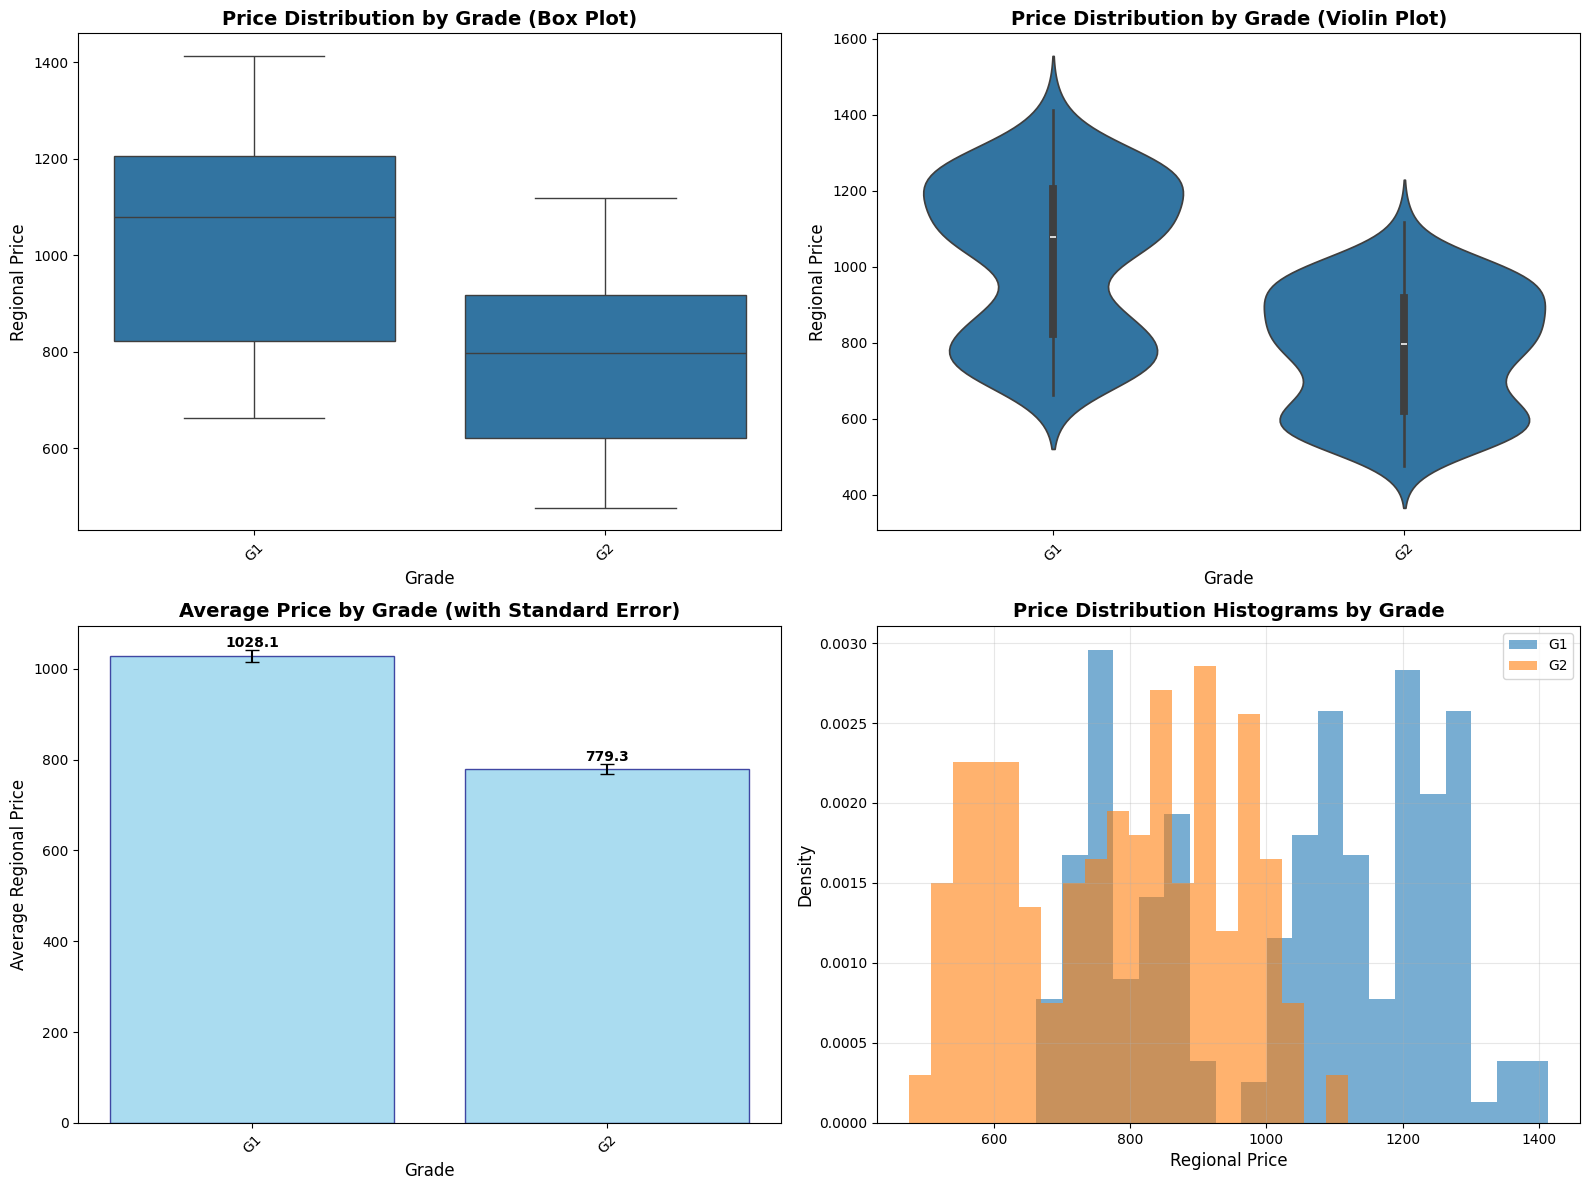


Price Distribution Summary by Grade:
       count     mean     std     min     25%      50%      75%      max
Grade                                                                   
G1     207.0  1028.06  205.73  662.70  822.24  1079.58  1205.05  1413.59
G2     207.0   779.26  160.01  476.19  621.32   796.80   917.79  1119.36


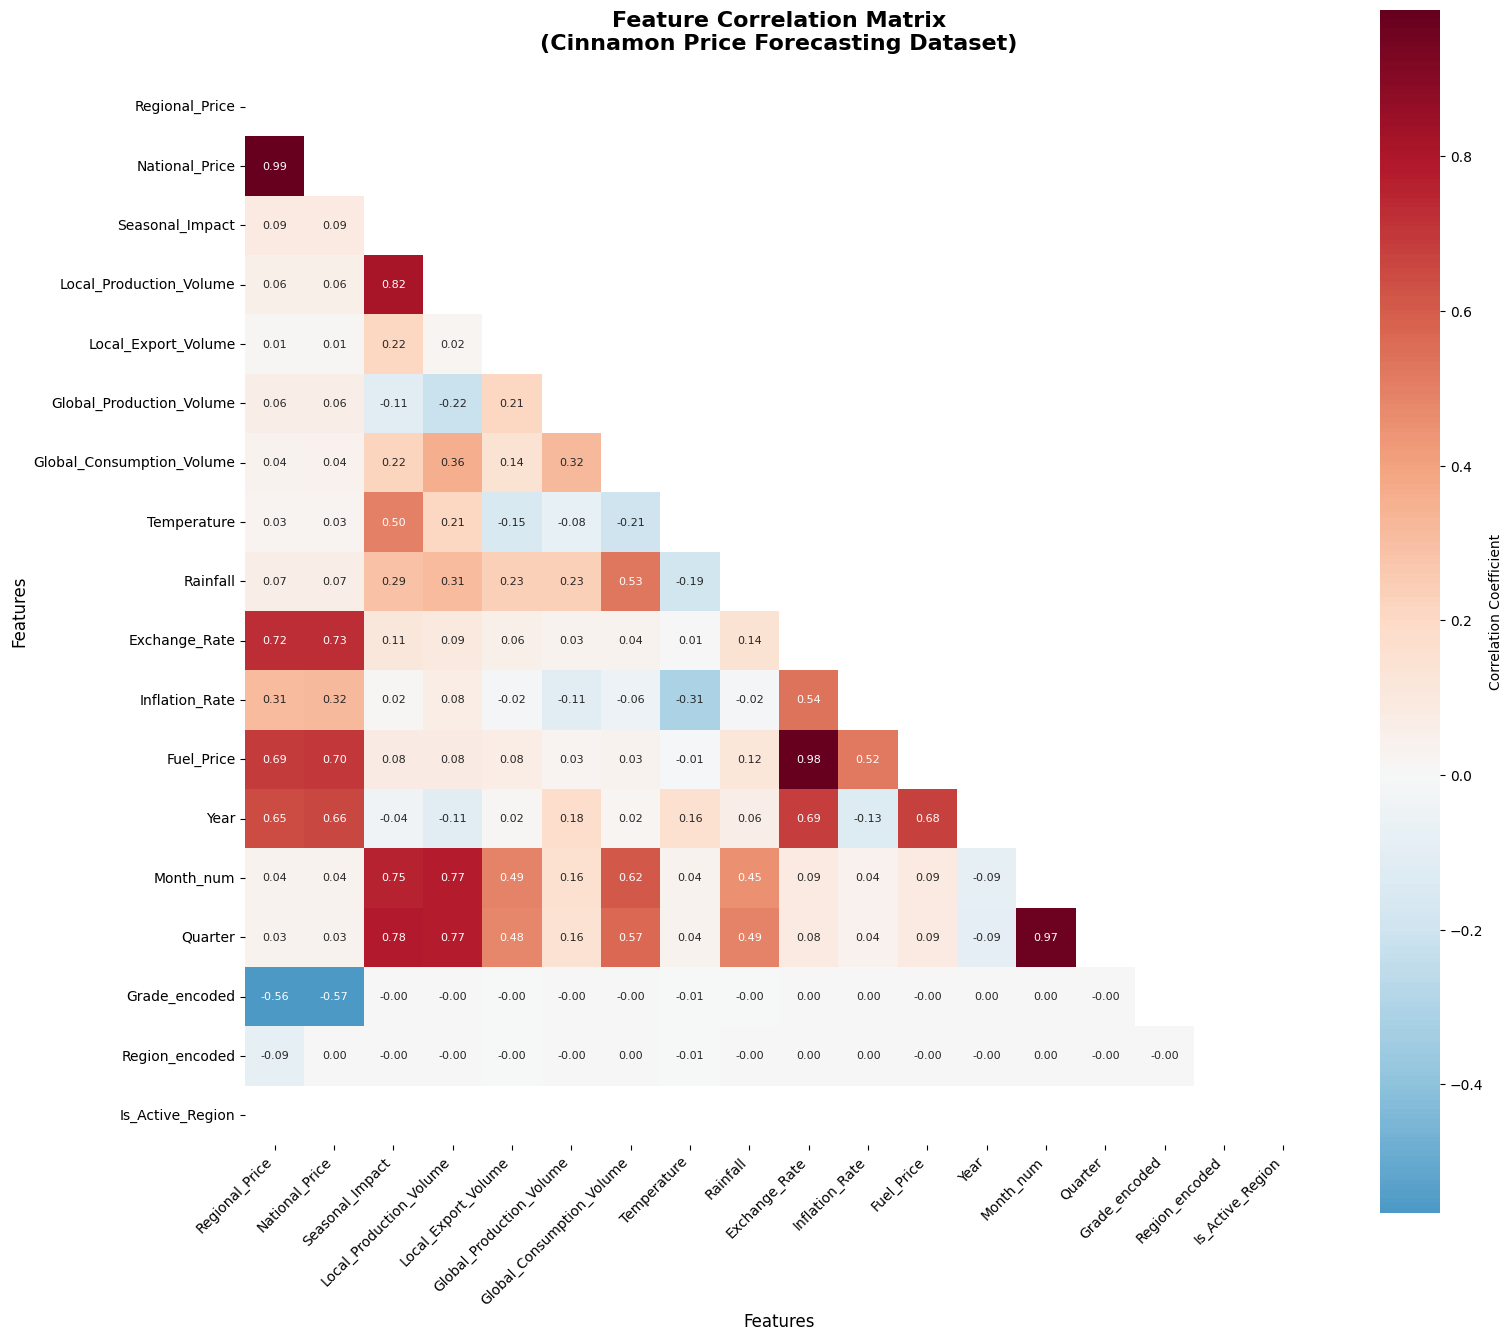


Highly Correlated Feature Pairs (|correlation| > 0.7):
Regional_Price ↔ National_Price: 0.990
Exchange_Rate ↔ Fuel_Price: 0.980
Month_num ↔ Quarter: 0.971
Seasonal_Impact ↔ Local_Production_Volume: 0.819
Seasonal_Impact ↔ Quarter: 0.777
Local_Production_Volume ↔ Quarter: 0.772
Local_Production_Volume ↔ Month_num: 0.772
Seasonal_Impact ↔ Month_num: 0.754
National_Price ↔ Exchange_Rate: 0.730
Regional_Price ↔ Exchange_Rate: 0.723

🤖 Step 3: Training LSTM model...
Preparing sequences...


[I 2025-10-24 10:36:08,557] A new study created in memory with name: no-name-4dc63af8-abc1-4206-8419-a4d0abdcaede


Total sequences created: 342
Created 342 sequences with shape (342, 12, 42)
Scaling features...
Training set shape: X=(204, 12, 42), y=(204,)
Validation set shape: X=(69, 12, 42), y=(69,)
Test set shape: X=(69, 12, 42), y=(69,)

🔧 Performing hyperparameter tuning using optuna method...

🚀 Starting Hyperparameter Tuning using OPTUNA method...

🎯 Starting Optuna Hyperparameter Tuning...


Best trial: 0. Best value: 0.111848:   1%|          | 1/100 [01:02<1:43:52, 62.95s/it]

[I 2025-10-24 10:37:11,510] Trial 0 finished with value: 0.11184842139482498 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.0003577736311175369, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 0 with value: 0.11184842139482498.


Best trial: 1. Best value: 0.0249238:   2%|▏         | 2/100 [01:48<1:25:55, 52.61s/it]

[I 2025-10-24 10:37:56,871] Trial 1 finished with value: 0.024923846125602722 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.4, 'dense_units': 16, 'learning_rate': 0.004002132408164753, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 1 with value: 0.024923846125602722.


Best trial: 1. Best value: 0.0249238:   3%|▎         | 3/100 [02:31<1:17:46, 48.11s/it]

[I 2025-10-24 10:38:39,636] Trial 2 finished with value: 0.2741069495677948 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0003163890950448524, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.024923846125602722.


Best trial: 1. Best value: 0.0249238:   4%|▍         | 4/100 [03:24<1:20:05, 50.05s/it]

[I 2025-10-24 10:39:32,667] Trial 3 finished with value: 0.14319439232349396 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0009688322108932755, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 1 with value: 0.024923846125602722.


Best trial: 4. Best value: 0.0194509:   5%|▌         | 5/100 [04:03<1:12:57, 46.08s/it]

[I 2025-10-24 10:40:11,692] Trial 4 finished with value: 0.019450945779681206 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 16, 'learning_rate': 0.0007129662792273286, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.019450945779681206.


Best trial: 4. Best value: 0.0194509:   6%|▌         | 6/100 [04:33<1:03:41, 40.65s/it]

[I 2025-10-24 10:40:41,803] Trial 5 finished with value: 0.0413580946624279 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0002806246055004124, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.019450945779681206.


Best trial: 4. Best value: 0.0194509:   7%|▋         | 7/100 [05:13<1:02:47, 40.51s/it]

[I 2025-10-24 10:41:22,038] Trial 6 finished with value: 0.020361604169011116 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0011438795226350142, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 4 with value: 0.019450945779681206.


Best trial: 4. Best value: 0.0194509:   8%|▊         | 8/100 [05:53<1:02:02, 40.47s/it]

[I 2025-10-24 10:42:02,402] Trial 7 finished with value: 0.02847352623939514 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.004243048123867851, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.019450945779681206.


Best trial: 4. Best value: 0.0194509:   9%|▉         | 9/100 [06:40<1:04:05, 42.26s/it]

[I 2025-10-24 10:42:48,611] Trial 8 finished with value: 0.04455569013953209 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.0001210258154932511, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 4 with value: 0.019450945779681206.


Best trial: 4. Best value: 0.0194509:  10%|█         | 10/100 [07:06<56:12, 37.47s/it] 

[I 2025-10-24 10:43:15,354] Trial 9 finished with value: 0.02932709828019142 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0004026426972006209, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.019450945779681206.


Best trial: 4. Best value: 0.0194509:  11%|█         | 11/100 [07:26<47:18, 31.89s/it]

[I 2025-10-24 10:43:34,584] Trial 10 finished with value: 0.5387222766876221 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.001344728022493764, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.019450945779681206.


Best trial: 11. Best value: 0.0182563:  12%|█▏        | 12/100 [08:08<51:34, 35.16s/it]

[I 2025-10-24 10:44:17,233] Trial 11 finished with value: 0.018256286159157753 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0013792121628919832, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 11 with value: 0.018256286159157753.


Best trial: 11. Best value: 0.0182563:  13%|█▎        | 13/100 [08:35<47:32, 32.78s/it]

[I 2025-10-24 10:44:44,543] Trial 12 finished with value: 0.02758980356156826 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.002347156028141718, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 11 with value: 0.018256286159157753.


Best trial: 11. Best value: 0.0182563:  14%|█▍        | 14/100 [09:14<49:21, 34.43s/it]

[I 2025-10-24 10:45:22,787] Trial 13 finished with value: 0.03949875012040138 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.00810743834647676, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 11 with value: 0.018256286159157753.


Best trial: 14. Best value: 0.0155995:  15%|█▌        | 15/100 [09:55<51:48, 36.58s/it]

[I 2025-10-24 10:46:04,328] Trial 14 finished with value: 0.015599511563777924 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0006819148988366753, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  16%|█▌        | 16/100 [10:29<50:01, 35.73s/it]

[I 2025-10-24 10:46:38,101] Trial 15 finished with value: 0.020479820668697357 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.002015148757544088, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  17%|█▋        | 17/100 [11:12<52:35, 38.01s/it]

[I 2025-10-24 10:47:21,420] Trial 16 finished with value: 0.015923013910651207 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0006472760491690734, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  18%|█▊        | 18/100 [11:58<55:08, 40.35s/it]

[I 2025-10-24 10:48:07,227] Trial 17 finished with value: 0.015764182433485985 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0005571446314558626, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  19%|█▉        | 19/100 [13:00<1:03:00, 46.67s/it]

[I 2025-10-24 10:49:08,601] Trial 18 finished with value: 0.15311242640018463 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.00016571257411110112, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  20%|██        | 20/100 [13:41<1:00:12, 45.16s/it]

[I 2025-10-24 10:49:50,250] Trial 19 finished with value: 0.017465941607952118 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.00048708359514692016, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  21%|██        | 21/100 [14:17<55:36, 42.23s/it]  

[I 2025-10-24 10:50:25,655] Trial 20 finished with value: 0.05250067636370659 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.00023254313276234939, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  22%|██▏       | 22/100 [15:10<59:04, 45.44s/it]

[I 2025-10-24 10:51:18,566] Trial 21 finished with value: 0.019486280158162117 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0006120658684096882, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  23%|██▎       | 23/100 [16:12<1:04:55, 50.59s/it]

[I 2025-10-24 10:52:21,163] Trial 22 finished with value: 0.019881384447216988 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0007373119721686426, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  24%|██▍       | 24/100 [17:11<1:07:13, 53.07s/it]

[I 2025-10-24 10:53:20,032] Trial 23 finished with value: 0.016138888895511627 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0005413721275846848, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  25%|██▌       | 25/100 [18:08<1:07:51, 54.29s/it]

[I 2025-10-24 10:54:17,165] Trial 24 finished with value: 0.017083490267395973 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0008855981960185937, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  26%|██▌       | 26/100 [18:51<1:02:42, 50.85s/it]

[I 2025-10-24 10:54:59,985] Trial 25 finished with value: 0.03359513729810715 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.00023535665201204384, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 14. Best value: 0.0155995:  27%|██▋       | 27/100 [19:29<57:18, 47.11s/it]  

[I 2025-10-24 10:55:38,367] Trial 26 finished with value: 0.10536649823188782 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.002158824159891875, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 14 with value: 0.015599511563777924.


Best trial: 27. Best value: 0.015022:  28%|██▊       | 28/100 [20:22<58:29, 48.74s/it] 

[I 2025-10-24 10:56:30,927] Trial 27 finished with value: 0.01502204779535532 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00046825643510771484, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  29%|██▉       | 29/100 [21:03<54:55, 46.42s/it]

[I 2025-10-24 10:57:11,910] Trial 28 finished with value: 0.05430399253964424 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0001829612060007577, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  30%|███       | 30/100 [21:58<57:07, 48.96s/it]

[I 2025-10-24 10:58:06,799] Trial 29 finished with value: 0.08063662797212601 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.00034691836924803833, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  31%|███       | 31/100 [22:49<57:09, 49.70s/it]

[I 2025-10-24 10:58:58,233] Trial 30 finished with value: 0.017715685069561005 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.00048045809159572624, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  32%|███▏      | 32/100 [23:32<54:02, 47.68s/it]

[I 2025-10-24 10:59:41,207] Trial 31 finished with value: 0.015283881686627865 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0007696964382641211, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  33%|███▎      | 33/100 [24:19<52:51, 47.33s/it]

[I 2025-10-24 11:00:27,714] Trial 32 finished with value: 0.023055989295244217 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.00040364631426163334, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  34%|███▍      | 34/100 [25:08<52:50, 48.04s/it]

[I 2025-10-24 11:01:17,423] Trial 33 finished with value: 0.02009737864136696 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.001527891794258288, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  35%|███▌      | 35/100 [25:58<52:38, 48.59s/it]

[I 2025-10-24 11:02:07,283] Trial 34 finished with value: 0.022944603115320206 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.0009327113732464489, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  36%|███▌      | 36/100 [26:45<51:17, 48.09s/it]

[I 2025-10-24 11:02:54,209] Trial 35 finished with value: 0.2374715656042099 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0008367848767463479, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  37%|███▋      | 37/100 [27:41<52:49, 50.31s/it]

[I 2025-10-24 11:03:49,710] Trial 36 finished with value: 0.026478441432118416 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0003038977137016073, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  38%|███▊      | 38/100 [28:15<47:06, 45.59s/it]

[I 2025-10-24 11:04:24,282] Trial 37 finished with value: 0.03305678069591522 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.0010724190852930615, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  39%|███▉      | 39/100 [28:52<43:48, 43.08s/it]

[I 2025-10-24 11:05:01,518] Trial 38 finished with value: 0.039617691189050674 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.00044061352455084944, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  40%|████      | 40/100 [29:55<48:54, 48.92s/it]

[I 2025-10-24 11:06:04,043] Trial 39 finished with value: 0.056454308331012726 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0031817005173783845, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  41%|████      | 41/100 [30:46<48:44, 49.56s/it]

[I 2025-10-24 11:06:55,094] Trial 40 finished with value: 0.016472486779093742 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0006162111127154648, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  42%|████▏     | 42/100 [31:46<51:03, 52.82s/it]

[I 2025-10-24 11:07:55,540] Trial 41 finished with value: 0.01560948695987463 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0006476250689082466, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  43%|████▎     | 43/100 [32:54<54:24, 57.28s/it]

[I 2025-10-24 11:09:03,218] Trial 42 finished with value: 0.016626175493001938 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0007280205551820998, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  44%|████▍     | 44/100 [33:58<55:18, 59.26s/it]

[I 2025-10-24 11:10:07,078] Trial 43 finished with value: 0.01689687930047512 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0011225725474424831, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  45%|████▌     | 45/100 [34:37<48:45, 53.19s/it]

[I 2025-10-24 11:10:46,140] Trial 44 finished with value: 0.02756289206445217 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0005446238185160294, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  46%|████▌     | 46/100 [35:44<51:27, 57.18s/it]

[I 2025-10-24 11:11:52,627] Trial 45 finished with value: 0.016099797561764717 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.00037641124389724387, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  47%|████▋     | 47/100 [36:28<47:00, 53.21s/it]

[I 2025-10-24 11:12:36,568] Trial 46 finished with value: 0.01531258225440979 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.001664130793559209, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  48%|████▊     | 48/100 [37:11<43:34, 50.29s/it]

[I 2025-10-24 11:13:20,040] Trial 47 finished with value: 0.01855945587158203 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.001769143508911958, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  49%|████▉     | 49/100 [37:50<39:46, 46.79s/it]

[I 2025-10-24 11:13:58,674] Trial 48 finished with value: 0.01986108347773552 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.003004509062469655, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  50%|█████     | 50/100 [38:34<38:21, 46.03s/it]

[I 2025-10-24 11:14:42,914] Trial 49 finished with value: 0.017006754875183105 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.005572553283894061, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  51%|█████     | 51/100 [39:23<38:19, 46.93s/it]

[I 2025-10-24 11:15:31,956] Trial 50 finished with value: 0.25893452763557434 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 128, 'learning_rate': 0.0013192466815990637, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  52%|█████▏    | 52/100 [39:58<34:41, 43.36s/it]

[I 2025-10-24 11:16:06,968] Trial 51 finished with value: 0.03128763288259506 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0007827254939946882, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  53%|█████▎    | 53/100 [40:40<33:40, 43.00s/it]

[I 2025-10-24 11:16:49,117] Trial 52 finished with value: 0.020252134650945663 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0009954146393119292, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  54%|█████▍    | 54/100 [41:40<36:49, 48.03s/it]

[I 2025-10-24 11:17:48,901] Trial 53 finished with value: 0.017671197652816772 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.001600603380995551, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  55%|█████▌    | 55/100 [42:33<37:16, 49.70s/it]

[I 2025-10-24 11:18:42,484] Trial 54 finished with value: 0.01908961497247219 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0006196689330051076, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  56%|█████▌    | 56/100 [43:15<34:41, 47.30s/it]

[I 2025-10-24 11:19:24,187] Trial 55 finished with value: 0.04784629866480827 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.000248309511651141, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  57%|█████▋    | 57/100 [44:00<33:19, 46.51s/it]

[I 2025-10-24 11:20:08,856] Trial 56 finished with value: 0.01835758425295353 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0012834900244888684, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  58%|█████▊    | 58/100 [44:40<31:19, 44.74s/it]

[I 2025-10-24 11:20:49,483] Trial 57 finished with value: 0.04839038848876953 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.0004994682427280331, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  59%|█████▉    | 59/100 [45:26<30:43, 44.95s/it]

[I 2025-10-24 11:21:34,919] Trial 58 finished with value: 0.017705194652080536 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0006836718809508597, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  60%|██████    | 60/100 [46:30<33:47, 50.68s/it]

[I 2025-10-24 11:22:38,967] Trial 59 finished with value: 0.020851189270615578 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.002586812640534177, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  61%|██████    | 61/100 [47:20<32:49, 50.51s/it]

[I 2025-10-24 11:23:29,060] Trial 60 finished with value: 0.03110509365797043 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0003378660239130223, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  62%|██████▏   | 62/100 [48:21<33:57, 53.62s/it]

[I 2025-10-24 11:24:29,954] Trial 61 finished with value: 0.016145052388310432 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.000587540787478599, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 27. Best value: 0.015022:  63%|██████▎   | 63/100 [49:28<35:37, 57.78s/it]

[I 2025-10-24 11:25:37,456] Trial 62 finished with value: 0.016147863119840622 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.00042614235046017327, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.01502204779535532.


Best trial: 63. Best value: 0.0143912:  64%|██████▍   | 64/100 [50:27<34:45, 57.94s/it]

[I 2025-10-24 11:26:35,771] Trial 63 finished with value: 0.014391216449439526 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.000864424057104177, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 63. Best value: 0.0143912:  65%|██████▌   | 65/100 [51:19<32:45, 56.16s/it]

[I 2025-10-24 11:27:27,762] Trial 64 finished with value: 0.01631877012550831 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0008560902459746184, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 63. Best value: 0.0143912:  66%|██████▌   | 66/100 [52:25<33:33, 59.23s/it]

[I 2025-10-24 11:28:34,172] Trial 65 finished with value: 0.017108555883169174 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0011895489785882197, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 63. Best value: 0.0143912:  67%|██████▋   | 67/100 [53:06<29:32, 53.72s/it]

[I 2025-10-24 11:29:15,017] Trial 66 finished with value: 0.22160457074642181 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0009965412623013856, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 63. Best value: 0.0143912:  68%|██████▊   | 68/100 [54:17<31:21, 58.81s/it]

[I 2025-10-24 11:30:25,686] Trial 67 finished with value: 0.016724061220884323 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0018607626611778063, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 63. Best value: 0.0143912:  69%|██████▉   | 69/100 [54:59<27:49, 53.85s/it]

[I 2025-10-24 11:31:07,968] Trial 68 finished with value: 0.03407945856451988 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0007189534286804211, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 63. Best value: 0.0143912:  70%|███████   | 70/100 [55:58<27:40, 55.36s/it]

[I 2025-10-24 11:32:06,862] Trial 69 finished with value: 0.024710670113563538 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00010702103403245916, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 63. Best value: 0.0143912:  71%|███████   | 71/100 [56:58<27:24, 56.72s/it]

[I 2025-10-24 11:33:06,764] Trial 70 finished with value: 0.022236602380871773 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0005198327695249608, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 63 with value: 0.014391216449439526.


Best trial: 71. Best value: 0.0129111:  72%|███████▏  | 72/100 [58:12<28:53, 61.93s/it]

[I 2025-10-24 11:34:20,832] Trial 71 finished with value: 0.012911067344248295 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0007977354520520018, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  73%|███████▎  | 73/100 [59:16<28:06, 62.47s/it]

[I 2025-10-24 11:35:24,587] Trial 72 finished with value: 0.017666839063167572 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0008256688408048683, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  74%|███████▍  | 74/100 [1:00:25<27:55, 64.45s/it]

[I 2025-10-24 11:36:33,658] Trial 73 finished with value: 0.014435866847634315 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0004709172061050226, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  75%|███████▌  | 75/100 [1:01:05<23:49, 57.19s/it]

[I 2025-10-24 11:37:13,922] Trial 74 finished with value: 0.014095944352447987 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.000924778206154185, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  76%|███████▌  | 76/100 [1:01:30<19:05, 47.71s/it]

[I 2025-10-24 11:37:39,516] Trial 75 finished with value: 0.018591202795505524 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0014767808445905776, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  77%|███████▋  | 77/100 [1:01:51<15:10, 39.58s/it]

[I 2025-10-24 11:38:00,129] Trial 76 finished with value: 0.02169557474553585 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0009701311065932012, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  78%|███████▊  | 78/100 [1:02:15<12:45, 34.81s/it]

[I 2025-10-24 11:38:23,790] Trial 77 finished with value: 0.014120749197900295 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0004416826342997955, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  79%|███████▉  | 79/100 [1:02:43<11:27, 32.75s/it]

[I 2025-10-24 11:38:51,734] Trial 78 finished with value: 0.18935537338256836 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00020269689925893743, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  80%|████████  | 80/100 [1:03:04<09:48, 29.43s/it]

[I 2025-10-24 11:39:13,426] Trial 79 finished with value: 0.017481310293078423 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00043539899821161664, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  81%|████████  | 81/100 [1:03:30<08:56, 28.22s/it]

[I 2025-10-24 11:39:38,834] Trial 80 finished with value: 0.01810770481824875 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0003853592901973218, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  82%|████████▏ | 82/100 [1:03:46<07:21, 24.54s/it]

[I 2025-10-24 11:39:54,780] Trial 81 finished with value: 0.020367775112390518 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0003112804838893909, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 71. Best value: 0.0129111:  83%|████████▎ | 83/100 [1:04:04<06:26, 22.72s/it]

[I 2025-10-24 11:40:13,261] Trial 82 finished with value: 0.020367590710520744 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.000754103243126094, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 71 with value: 0.012911067344248295.


Best trial: 83. Best value: 0.0128669:  84%|████████▍ | 84/100 [1:04:30<06:18, 23.66s/it]

[I 2025-10-24 11:40:39,108] Trial 83 finished with value: 0.012866880744695663 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00046949782945208545, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  85%|████████▌ | 85/100 [1:04:57<06:08, 24.59s/it]

[I 2025-10-24 11:41:05,853] Trial 84 finished with value: 0.015130291692912579 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00027165748848871065, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  86%|████████▌ | 86/100 [1:05:23<05:51, 25.07s/it]

[I 2025-10-24 11:41:32,066] Trial 85 finished with value: 0.01587878353893757 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0002939081804358253, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  87%|████████▋ | 87/100 [1:05:54<05:50, 26.93s/it]

[I 2025-10-24 11:42:03,333] Trial 86 finished with value: 0.025045452639460564 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00034551804012285736, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  88%|████████▊ | 88/100 [1:06:26<05:39, 28.27s/it]

[I 2025-10-24 11:42:34,741] Trial 87 finished with value: 0.024483008310198784 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00013447651136186856, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  89%|████████▉ | 89/100 [1:06:58<05:24, 29.54s/it]

[I 2025-10-24 11:43:07,238] Trial 88 finished with value: 0.024669518694281578 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0002525221656161606, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  90%|█████████ | 90/100 [1:07:30<05:01, 30.19s/it]

[I 2025-10-24 11:43:38,939] Trial 89 finished with value: 0.015112933702766895 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00046800236933288965, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  91%|█████████ | 91/100 [1:07:55<04:17, 28.64s/it]

[I 2025-10-24 11:44:03,968] Trial 90 finished with value: 0.01586640067398548 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00044771507083337514, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  92%|█████████▏| 92/100 [1:08:24<03:49, 28.65s/it]

[I 2025-10-24 11:44:32,645] Trial 91 finished with value: 0.016175376251339912 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0005606624935734943, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  93%|█████████▎| 93/100 [1:08:54<03:23, 29.06s/it]

[I 2025-10-24 11:45:02,673] Trial 92 finished with value: 0.016091827303171158 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0002731088917954641, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  94%|█████████▍| 94/100 [1:09:25<02:58, 29.74s/it]

[I 2025-10-24 11:45:33,991] Trial 93 finished with value: 0.014932820573449135 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00047774744405664393, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  95%|█████████▌| 95/100 [1:09:57<02:32, 30.54s/it]

[I 2025-10-24 11:46:06,397] Trial 94 finished with value: 0.01749655418097973 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00045639685824846836, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  96%|█████████▌| 96/100 [1:10:29<02:04, 31.01s/it]

[I 2025-10-24 11:46:38,513] Trial 95 finished with value: 0.015569915063679218 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.000495888694514143, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  97%|█████████▋| 97/100 [1:11:04<01:36, 32.20s/it]

[I 2025-10-24 11:47:13,485] Trial 96 finished with value: 0.13147073984146118 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0003742394133285616, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  98%|█████████▊| 98/100 [1:11:39<01:05, 32.77s/it]

[I 2025-10-24 11:47:47,578] Trial 97 finished with value: 0.01423385739326477 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0006376507057751418, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669:  99%|█████████▉| 99/100 [1:12:10<00:32, 32.31s/it]

[I 2025-10-24 11:48:18,814] Trial 98 finished with value: 0.01663600467145443 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0006692098412849516, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 83 with value: 0.012866880744695663.


Best trial: 83. Best value: 0.0128669: 100%|██████████| 100/100 [1:12:39<00:00, 43.60s/it]


[I 2025-10-24 11:48:48,470] Trial 99 finished with value: 0.025328243151307106 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0005395310516304296, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 83 with value: 0.012866880744695663.

🎉 Optuna Tuning Complete!
Best validation loss: 0.012867
Best parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00046949782945208545, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}

📊 Hyperparameter Tuning Results:
Best validation loss: 0.012867
Best parameters:
  units1: 512
  units2: 256
  dropout1: 0.1
  dropout2: 0.1
  dense_units: 128
  learning_rate: 0.00046949782945208545
  layer_type: GRU
  use_batch_norm: False
  optimizer: adam

Building final model with optimized parameters...

📋 Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 512)        │       854,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,478,401 (5.64 MB)

 Trainable params: 1,478,401 (5.64 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - loss: 0.4623 - mae: 0.5228 - val_loss: 0.2186 - val_mae: 0.3365 - learning_rate: 4.6950e-04
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.1358 - mae: 0.2874 - val_loss: 0.1159 - val_mae: 0.2415 - learning_rate: 4.6950e-04
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.0678 - mae: 0.2035 - val_loss: 0.0600 - val_mae: 0.1758 - learning_rate: 4.6950e-04
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.0445 - mae: 0.1665 - val_loss: 0.0478 - val_mae: 0.1631 - learning_rate: 4.6950e-04
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0381 - mae: 0.1543 - val_loss: 0.0406 - val_mae: 0.1482 - learning_rate: 4.6950e-04
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0263 - mae: 0.1318 - val_loss: 0.0403 - val_mae: 0.1448 - learning_rate: 4.6950e-04
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.0237 - mae: 0.1227 - val_loss: 0.0315 - val_

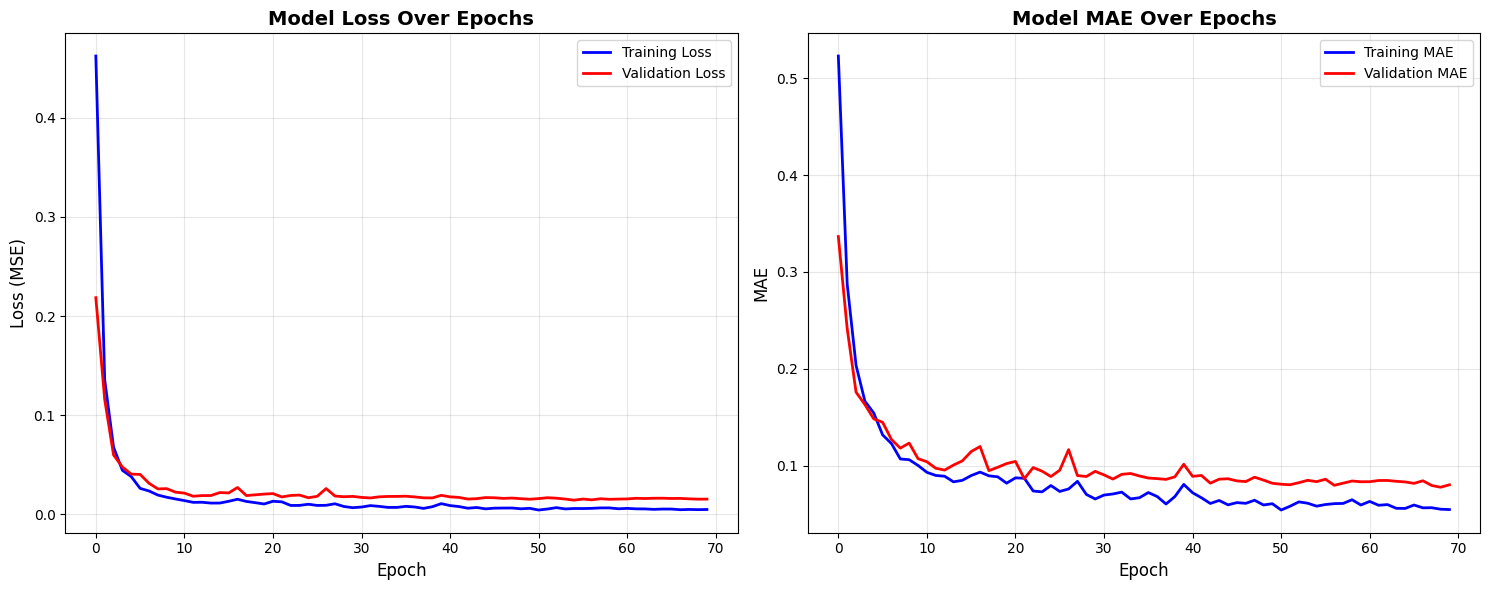


Final Training Metrics:
Training Loss: 0.0050
Validation Loss: 0.0154
Training MAE: 0.0547
Validation MAE: 0.0802

Evaluating final model on test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step

🎯 Final Model Performance on Test Set:
MAE: 19.27
RMSE: 28.42
R²: 0.9850

💾 Step 4: Saving trained model...

💾 Saving model to: cinnamon_models/Quillings\cinnamon_model_20251024_115023
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: cinnamon_models/Quillings\cinnamon_model_20251024_115023

📊 Saved Model Summary:
  • Performance: MAE=19.27, RMSE=28.42, R²=0.9850
  • Hyperparameter tuning: optuna method used
  • Best parameters found and applied
  • Training epochs: 70
  • Total parameters: 1,478,401
✅ Model saved at: cinnamon_models/Quillings\cinnamon_model_20251024_115023

🔮 Step 5: Generating sample forecasts...
Available grades: ['G1' 'G2']
Available regi

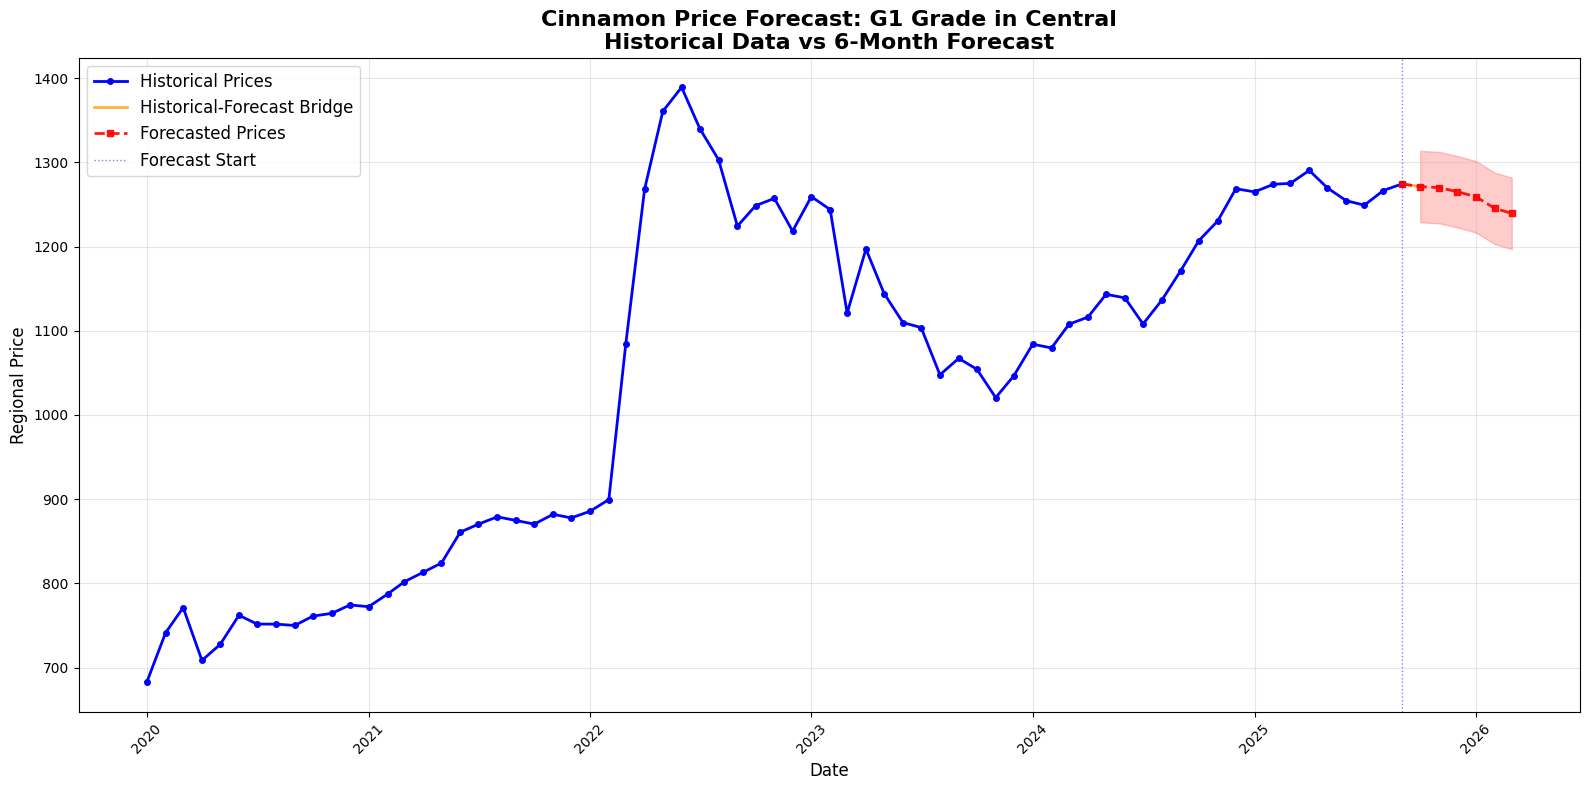


G1 Grade Forecast for Central:
Month  1 (2025-10): LKR  1271.14
Month  2 (2025-11): LKR  1269.98
Month  3 (2025-12): LKR  1265.21
Month  4 (2026-01): LKR  1259.09
Month  5 (2026-02): LKR  1245.32
Month  6 (2026-03): LKR  1239.40

Forecast Statistics:
Average Forecast Price: LKR 1258.36
Price Range: LKR 1239.40 - LKR 1271.14
Overall Trend: decreasing by LKR 5.29 per month

🎯 TRAINING SUMMARY
✅ Hyperparameter tuning: optuna method used
🏆 Best parameters found:
   • units1: 512
   • units2: 256
   • dropout1: 0.1
   • dropout2: 0.1
   • dense_units: 128
   • learning_rate: 0.00046949782945208545
   • layer_type: GRU
   • use_batch_norm: False
   • optimizer: adam

📊 Final Model Performance:
   • MAE: 19.2725
   • RMSE: 28.4209
   • R²: 0.9850
   • Training epochs: 70

✅ Training complete! Model is ready for forecasting.


In [50]:
if __name__ == "__main__":
    print("=" * 80)
    print("🚀 CINNAMON PRICE FORECASTING WITH LSTM")
    print("=" * 80)
    

    DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Quillings_Dataset.csv'  
    USE_HYPERPARAMETER_TUNING = True  
    TUNING_METHOD = 'optuna'  # Options: 'optuna', 'random'
    N_TUNING_TRIALS = 100
    
    # Step 1: Load and prepare data
    print("\n📊 Step 1: Loading and preparing data...")
    df = load_and_prepare_data(DATA_PATH)
    print(f"✅ Data loaded successfully! Shape: {df.shape}")
    
    # Step 2: Visualizations
    print("\n📈 Step 2: Generating visualizations...")
    plot_price_distribution_by_grade(df)
    plot_feature_correlation_matrix(df)
    
    # Step 3: Train model
    print("\n🤖 Step 3: Training LSTM model...")
    model, history, metrics = train_model(
        df, 
        use_tuning=USE_HYPERPARAMETER_TUNING,
        tuning_method=TUNING_METHOD,
        n_tuning_trials=N_TUNING_TRIALS
    )
    
    # Step 4: Save model
    print("\n💾 Step 4: Saving trained model...")
    saved_model_path = save_model(model, metrics)
    print(f"✅ Model saved at: {saved_model_path}")
    
    # Step 5: Generate forecasts
    print("\n🔮 Step 5: Generating sample forecasts...")
    available_grades = df['Grade'].unique()
    available_regions = df['Region'].unique()
    
    print(f"Available grades: {available_grades}")
    print(f"Available regions: {available_regions}")
    
    # Generate forecast for first combination
    if len(available_grades) > 0 and len(available_regions) > 0:
        grade_to_forecast = available_grades[0]
        region_to_forecast = available_regions[0]
        
        print(f"\n📈 Generating 6-month forecast for {grade_to_forecast} in {region_to_forecast}...")
        forecasts, future_dates = plot_forecast_results(
            df, model, grade_to_forecast, region_to_forecast, months_ahead=6
        )
    
    # Print summary
    print("\n" + "=" * 80)
    print("🎯 TRAINING SUMMARY")
    print("=" * 80)
    
    if metrics.get('tuning_used'):
        print(f"✅ Hyperparameter tuning: {metrics['tuning_method']} method used")
        print(f"🏆 Best parameters found:")
        for key, value in metrics['best_params'].items():
            print(f"   • {key}: {value}")
    else:
        print("❌ Hyperparameter tuning was skipped - default parameters used")
    
    print(f"\n📊 Final Model Performance:")
    print(f"   • MAE: {metrics['mae']:.4f}")
    print(f"   • RMSE: {metrics['rmse']:.4f}")
    print(f"   • R²: {metrics['r2']:.4f}")
    print(f"   • Training epochs: {metrics['epochs_trained']}")
    
    print("\n✅ Training complete! Model is ready for forecasting.")
    print("=" * 80)